In [3]:
import seaborn as sns
import cv2
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Face Mask Detection 

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing masks, not wearing them, or wearing masks improperly.

## What's data we have ?

This dataset contains 853 images belonging to the 3 classes, as well as their bounding boxes in the PASCAL VOC format.
The classes are:
- With mask;
- Without mask;
- Mask worn incorrectly.

So we have images in images folder and annotations available in annotations folder.
This dataset come from kaggle, here the source: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

## Data Preparation
To prepare our data for the model, we have tranform it in two step:
1. Get the data in a dataframe with these columns
    - file_name
    - label
    - xmin
    - xmax
    - ymin
    - ymax
2. Crop Original image and create a dataframe with
    - cropped_image
    - label
    - name

In [4]:
# Let's create paths
images_path = []
annotations_path = []

for dirname, _, filenames in os.walk('dataset/facemask/'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path[-3:] == 'xml':
            annotations_path.append(file_path)
        else:
            images_path.append(file_path)
            
print("We load all images" if len(images_path) == 853 else "Oops...")

We load all images


In [5]:
import xml.etree.ElementTree as ET

# First dataframe
df = pd.DataFrame(columns=['file_name', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])

for xml_file in annotations_path:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    file_name = root.find('filename').text
#     foreach object
    for obj in root.findall('object'):
        row = {
            'file_name': file_name,
            'label': obj.find('name').text,
            'xmin': int(obj.find('bndbox').find('xmin').text),
            'ymin': int(obj.find('bndbox').find('ymin').text),
            'xmax': int(obj.find('bndbox').find('xmax').text),
            'ymax': int(obj.find('bndbox').find('ymax').text)
        }
        df = df.append(row, ignore_index=True)

C:\Users\saraZ\AppData\Local\Temp\ipykernel_28784\3840804405.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\saraZ\AppData\Local\Temp\ipykernel_28784\3840804405.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\saraZ\AppData\Local\Temp\ipykernel_28784\3840804405.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\saraZ\AppData\Local\Temp\ipykernel_28784\3840804405.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\saraZ\AppData\Local\Tem

In [6]:
df

,file_name,label,xmin,ymin,xmax,ymax
0,maksssksksss0.png,without_mask,79,105,109,142
1,maksssksksss0.png,with_mask,185,100,226,144
2,maksssksksss0.png,without_mask,325,90,360,141
3,maksssksksss1.png,with_mask,321,34,354,69
4,maksssksksss1.png,with_mask,224,38,261,73
...,...,...,...,...,...,...
4067,maksssksksss98.png,with_mask,263,62,287,85
4068,maksssksksss98.png,with_mask,344,80,377,106
4069,maksssksksss99.png,mask_weared_incorrect,181,54,273,162
4070,maksssksksss99.png,with_mask,99,87,176,165


<AxesSubplot: xlabel='label', ylabel='count'>

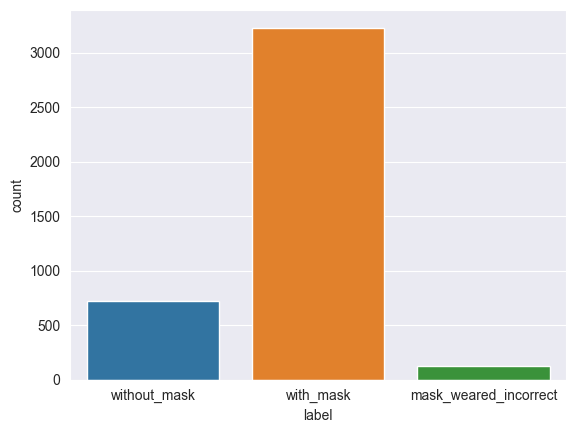

In [7]:
sns.countplot(x=df.label)

In [8]:
df.label.value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: label, dtype: int64

In [9]:
# Let's create a function to crop images and create final image
BASE_DIR_IMG = 'dataset/facemask/images/'
def crop_image(file, xmin, ymin, xmax, ymax, is_im_arr=False):
    if is_im_arr is False:
        im = Image.open(BASE_DIR_IMG + file)
        im_arr = np.array(im)
    else:
        im_arr = np.array(file)
    # cropping
    im_cropped = im_arr[ymin:ymax, xmin:xmax, :3]
    return im_cropped

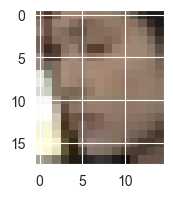

In [10]:
# Test our crop_image function
row = df.iloc[200]
im_cropped = crop_image(row.file_name, row.xmin, row.ymin, row.xmax, row.ymax)
# plot image cropped
plt.figure(figsize=(2,2))
plt.imshow(im_cropped)
plt.show()

Great, our function crop well. Now, we resize our images

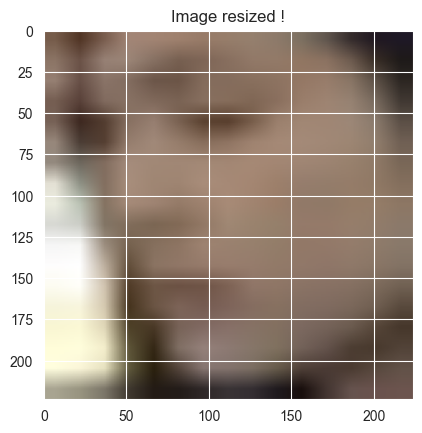

In [11]:
plt.imshow(cv2.resize(im_cropped, (224, 224)))
plt.title("Image resized !")
plt.show()

In [12]:
# create data batch
def create_data_batch(X, y=None, batch_size=32, valid_data=False, test_data=False):
    """
        We create dataset and iter to transform file_path to cropped image
    """
    if test_data:
        print('Creating test dataset')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.batch(batch_size)
    elif valid_data:
        print('Creating valid dataset')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.batch(batch_size)
    else:
        print('Creating Training dataset')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.batch(batch_size)
    return data_batch

In [13]:
# Let's merge all of this
images = []
labels = []
for i in range(len(df)):
    row = df.iloc[i]
    im_cropped = crop_image(row.file_name, row.xmin, row.ymin, row.xmax, row.ymax)
    im_resized = cv2.resize(im_cropped, (50, 50))
    im_resized = im_resized / 255.0
    images.append(im_resized)
    labels.append(row.label)
len(images), len(labels)

(4072, 4072)

In [14]:
# encode labels
le = preprocessing.LabelEncoder()
labels_encoder = le.fit_transform(labels)
targets = np.array(labels_encoder)
targets.shape

(4072,)

#### Always split data into training, validation, test ...

In [15]:
X_data, X_test, y_data, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)
len(X_data)

3664

In [16]:
# validation set
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(2931, 2931, 733, 733)

In [17]:
train_data = create_data_batch(X_train, y=y_train)
train_data.element_spec

Creating Training dataset


(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [18]:
val_data = create_data_batch(X_val, y=y_val, valid_data=True)
val_data.element_spec

Creating valid dataset


(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [19]:
test_data = create_data_batch(X_test, test_data=True)

Creating test dataset


Phew ... preparation is finished, now we build the model

## Data Modeling

In [20]:
# to modify
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=[5,5], activation='relu', padding='same', name='conv1'))
model.add(tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2, name='pool1'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=[5,5], padding='same', activation='relu', name='conv2'))
model.add(tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2, name='pool2'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu', name='dense'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax', name='logits'))

# compile
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
)

# build
model.build([None, 50, 50, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 50, 50, 16)        1216      
                                                                 
 pool1 (MaxPooling2D)        (None, 25, 25, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 25, 25, 32)        12832     
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 12, 32)        0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [22]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
# create a squeeze Net class
class SqueeezNetModel(object):
    
    # convert final convolution to logits
    def get_logits(self, conv_layer):
        avg_pool1 = tf.keras.layers.AveragePooling2D([conv_layer.shape[1], conv_layer.shape[2]], 1)(conv_layer)
        logits = tf.keras.layers.Flatten(name='logits')(avg_pool1)
        return logits
    
    def create_conv2D(self, inputs, filters, kernel_size, name):
        return tf.keras.layers.Conv2D(
                filters=filters,
                kernel_size=kernel_size,
                padding='same',
                activation='relu',
                name=name
        )(inputs)
    
    def create_max_pooling2D(self, inputs, name):
        return tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2, name=name)(inputs)
    
    def fire_module(self, fire_input, squeeze_depth, expand_depth, name):
        squeeze_inputs = self.create_conv2D(fire_input, 
                                            squeeze_depth, 
                                            [1,1], 
                                            name=name + "_squeeze")
        expand1x1 = self.create_conv2D(squeeze_inputs, expand_depth, [1,1], name=name + '_expand1x1')
        expand3x3 = self.create_conv2D(squeeze_inputs, expand_depth, [3,3], name=name + '_expand3x3')
        return tf.concat([expand1x1, expand3x3], axis=-1)
    
    def stack_fire_module(self, layer, params_list):
        for params in params_list:
            layer = self.fire_module(layer, *params)
        return layer
    
    def build_model(self, input_shape: list=[50,50,3], is_training=False):
        # inputs shape
        x = tf.keras.Input(shape=input_shape)
        # Conv2D + MaxPooling
        conv1 = self.create_conv2D(x, 64, [3, 3], name='conv1')
        pool1 = self.create_max_pooling2D(conv1, name='pool1')
        # Squeeze Net
        fire_params = [
            [32, 128, 'fire1'],
#             [32, 64, 'fire2']
        ]
        multi_fire = self.stack_fire_module(pool1, fire_params)
#         pool2 = self.create_max_pooling2D(multi_fire, 'pool2')
#         fire_params2 = [
#             (32, 128, 'fire3'),
#             (32, 128, 'fire4')
#         ]
#         multi_fire_2 = self.stack_fire_module(pool2, fire_params2)
        dropout = tf.keras.layers.Dropout(rate=0.2)(multi_fire, training=is_training)
        conv_layer = self.create_conv2D(dropout, 3, [1, 1], 'final_conv')
        model = tf.keras.Model(x, self.get_logits(conv_layer))
        return model
        

In [24]:
model_squeeze = SqueeezNetModel()
model_squeeze = model_squeeze.build_model()
model_squeeze.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 50, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 pool1 (MaxPooling2D)           (None, 25, 25, 64)   0           ['conv1[0][0]']                  
                                                                                                  
 fire1_squeeze (Conv2D)         (None, 25, 25, 32)   2080        ['pool1[0][0]']                  
                                                                                              

In [25]:
model_squeeze.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [26]:
plot_model(model_squeeze, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
# create callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

In [28]:
%time
history_1 = model.fit(x=train_data, validation_data=val_data, epochs=20, callbacks=[early_stopping])

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/20
92/92 [==============================] - 10s 96ms/step - loss: 0.3584 - accuracy: 0.8833 - val_loss: 0.2508 - val_accuracy: 0.9318
Epoch 2/20
92/92 [==============================] - 8s 90ms/step - loss: 0.2265 - accuracy: 0.9263 - val_loss: 0.2550 - val_accuracy: 0.9236
Epoch 3/20
92/92 [==============================] - 8s 87ms/step - loss: 0.1951 - accuracy: 0.9355 - val_loss: 0.2267 - val_accuracy: 0.9291
Epoch 4/20
92/92 [==============================] - 8s 88ms/step - loss: 0.1765 - accuracy: 0.9410 - val_loss: 0.2283 - val_accuracy: 0.9304
Epoch 5/20
92/92 [==============================] - 8s 88ms/step - loss: 0.1645 - accuracy: 0.9403 - val_loss: 0.2055 - val_accuracy: 0.9372
Epoch 6/20
92/92 [==============================] - 8s 90ms/step - loss: 0.1583 - accuracy: 0.9481 - val_loss: 0.2615 - val_accuracy: 0.9113
Epoch 7/20
92/92 [==============================] - 8s 89ms/step - loss: 0.1506 - accuracy: 0.9471 - val_loss: 0.1

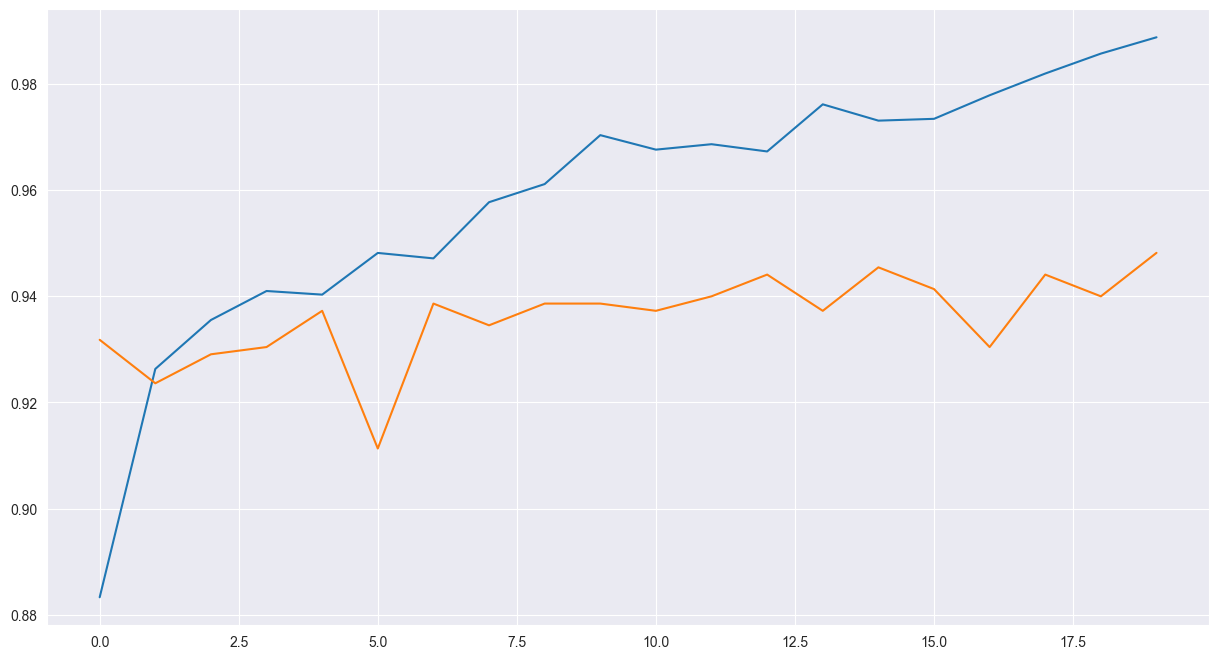

In [29]:
# Plotting Model Accuracy 
plt.figure(figsize=(15,8))
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.show()

In [30]:
%time
history_2 = model_squeeze.fit(x=train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping])

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/10
92/92 [==============================] - 11s 108ms/step - loss: 0.8719 - accuracy: 0.7748 - val_loss: 0.8165 - val_accuracy: 0.8786
Epoch 2/10
92/92 [==============================] - 10s 105ms/step - loss: 0.6653 - accuracy: 0.8628 - val_loss: 0.7790 - val_accuracy: 0.8977
Epoch 3/10
92/92 [==============================] - 10s 105ms/step - loss: 0.6659 - accuracy: 0.8618 - val_loss: 0.9648 - val_accuracy: 0.8131
Epoch 4/10
92/92 [==============================] - 11s 115ms/step - loss: 0.6510 - accuracy: 0.8755 - val_loss: 0.8108 - val_accuracy: 0.9018
Epoch 5/10
92/92 [==============================] - 11s 124ms/step - loss: 0.5800 - accuracy: 0.9000 - val_loss: 0.8245 - val_accuracy: 0.8704
Epoch 6/10
92/92 [==============================] - 10s 104ms/step - loss: 0.5711 - accuracy: 0.8946 - val_loss: 0.6593 - val_accuracy: 0.8813
Epoch 7/10
92/92 [==============================] - 10s 105ms/step - loss: 0.6433 - accuracy: 0.8727 - 

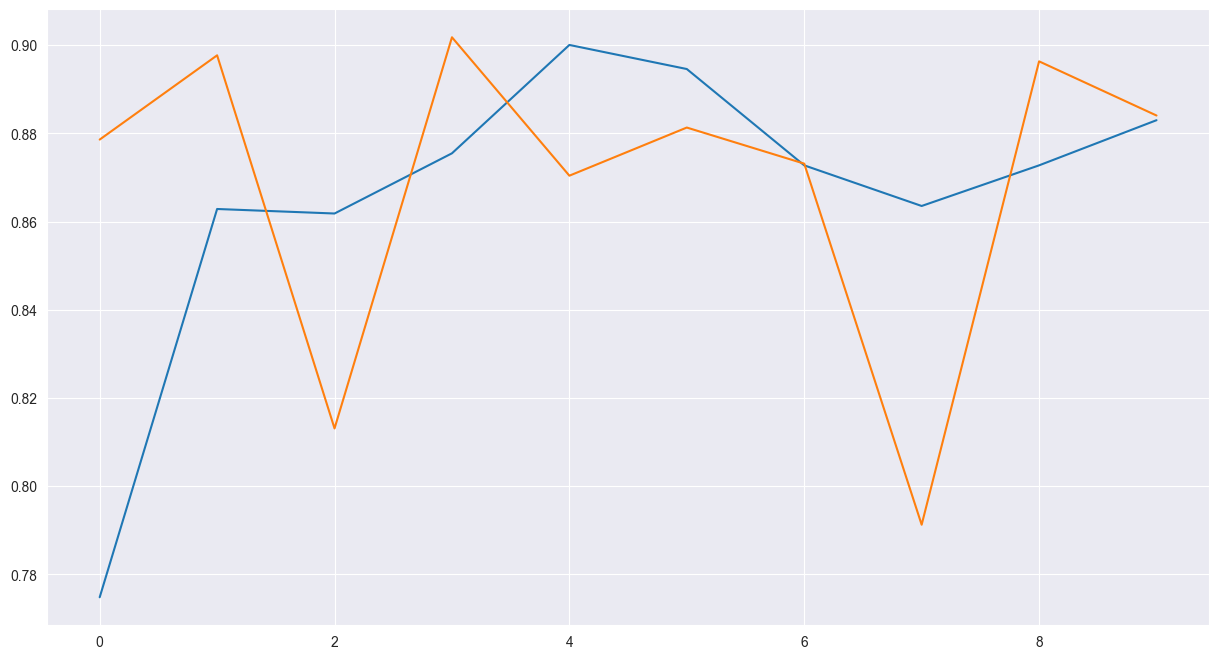

In [31]:
plt.figure(figsize=(15,8))
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.show()

Phew ... We have two models, the simple CNN is more accurate and consumes much memory but the squeezeNet is less accurate and consumes less memory. For me, there is no better choice, it all depends on needs. For the next step, I want to use the SqueezeNet Model

Why accurate of SqueezeNet decrease ? 
it due to the **degradation**,if we have many layers,it causes the model to have lower accuracy in both training and testing.

in the next version, I'll fix this issue with ResNet Model.

## Data Evaluation

For the next Step, I want to use the Simple CNN.

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
test_data = create_data_batch(X_test, test_data=True)
test_data.element_spec

Creating test dataset


TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None)

In [34]:
y_preds = model.predict(test_data).argmax(axis=1)

13/13 [==============================] - 0s 13ms/step


In [35]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.98      0.99      0.98       326
           2       0.94      0.85      0.89        72

    accuracy                           0.96       408
   macro avg       0.82      0.84      0.83       408
weighted avg       0.96      0.96      0.96       408



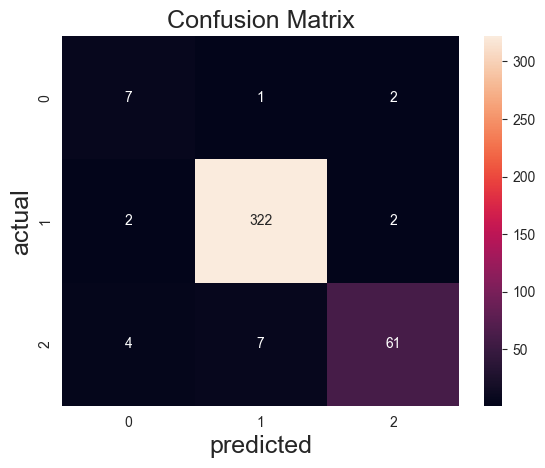

In [36]:
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='g')
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

## Final Test - Real World Case

We took a random image online 

In [6]:
from skimage import io

image = io.imread("http://prod-upp-image-read.ft.com/53e5e116-5e34-11ea-ac5e-df00963c20e6")
image.shape

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\saraZ\\AppData\\Local\\Temp\\tmpu_d2skzf'

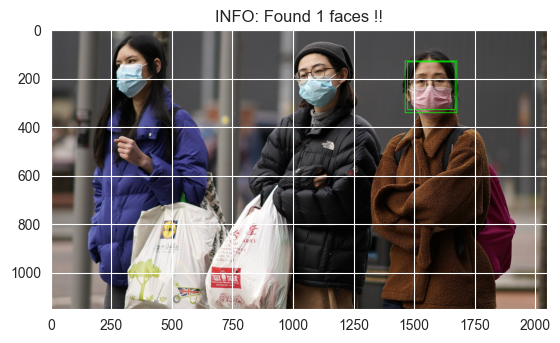

In [7]:
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray_img,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(50, 50)
)

plt.title(f"INFO: Found {len(faces)} faces !!")
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(image)
plt.show()

In [8]:
# Great now we extract faces and make predictions
for (x, y, w, h) in faces:
    ymin, ymax, xmin, xmax = y, y+h, x, x+w
    im_cropped = crop_image(image, xmin, ymin, xmax, ymax, is_im_arr=True)
    im_resized = cv2.resize(im_cropped, (50, 50))
    im_resized = im_resized / 255.0
    im_test = tf.constant([im_resized])
    y_pred = model.predict(im_test).argmax(axis=1)
    plt.figure(figsize=(10,5))
    plt.title(le.inverse_transform(y_pred))
    plt.imshow(im_cropped)

NameError: name 'crop_image' is not defined